In [4]:
DATASET_DIR = ''
#GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd
import keras
from keras.callbacks import EarlyStopping

environment='L'


In [5]:

if environment == 'S':
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'  
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth =\
        True
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
elif environment == 'L':
    os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")

In [6]:


X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'), encoding='ISO-8859-1')
X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])
#X = (X[(X["essay_set"] == 1)])
y = X['domain1_score_copy']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")


Preprocessing the Data
We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [7]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs


Defining the model
Here we define a 2-Layer LSTM Model.

Note that instead of using sigmoid activation in the output layer we will use Relu since we are not normalising training labels.



In [8]:

from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from keras.utils.np_utils import to_categorical


def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    #model.add(Dense(12, activation='softmax'))
    model.add(Dense(12, activation='sigmoid'))
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model
'''
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model
'''

'\nfrom keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten\nfrom keras.models import Sequential, load_model, model_from_config\nimport keras.backend as K\n\ndef get_model():\n    """Define the model."""\n    model = Sequential()\n    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))\n    model.add(LSTM(64, recurrent_dropout=0.4))\n    model.add(Dropout(0.5))\n    model.add(Dense(1, activation=\'relu\'))\n\n    model.compile(loss=\'mean_squared_error\', optimizer=\'rmsprop\', metrics=[\'mae\'])\n    model.summary()\n\n    return model\n'

Training Phase
Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold. We will then calculate Average Kappa for all the folds.


--------Fold 1--------



Training Word2Vec Model...


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                780       
Total params: 815,420
Trainable params: 815,420
Non-trainable params: 0
_________________________________________________________________


Train on 2866 samples, validate on 200 samples
Epoch 1/50


  64/2866 [..............................] - ETA: 4:55 - loss: 0.6931 - acc: 0.5052

 192/2866 [=>............................] - ETA: 1:34 - loss: 0.6914 - acc: 0.7600

 320/2866 [==>...........................] - ETA: 54s - loss: 0.6897 - acc: 0.8198 

 448/2866 [===>..........................] - ETA: 37s - loss: 0.6876 - acc: 0.8469

 576/2866 [=====>........................] - ETA: 27s - loss: 0.6853 - acc: 0.8614

 704/2866 [======>.......................] - ETA: 21s - loss: 0.6824 - acc: 0.8705

 832/2866 [=======>......................] - ETA: 17s - loss: 0.6793 - acc: 0.8767

 960/2866 [=========>....................] - ETA: 14s - loss: 0.6752 - acc: 0.8813

1088/2866 [==========>...................] - ETA: 11s - loss: 0.6708 - acc: 0.8848

1216/2866 [===========>..................] - ETA: 9s - loss: 0.6655 - acc: 0.8871 

1344/2866 [=============>................] - ETA: 8s - loss: 0.6594 - acc: 0.8895

1472/2866 [==============>...............] - ETA: 7s - loss: 0.6526 - acc: 0.8919

1600/2866 [===============>..............] - ETA: 5s - loss: 0.6449 - acc: 0.8937

1728/2866 [=================>............] - ETA: 4s - loss: 0.6362 - acc: 0.8954

1856/2866 [==================>...........] - ETA: 4s - loss: 0.6265 - acc: 0.8969

1984/2866 [===================>..........] - ETA: 3s - loss: 0.6158 - acc: 0.8982

2112/2866 [=====================>........] - ETA: 2s - loss: 0.6040 - acc: 0.8993

2240/2866 [======================>.......] - ETA: 2s - loss: 0.5922 - acc: 0.9003

2368/2866 [=======================>......] - ETA: 1s - loss: 0.5800 - acc: 0.9011

2496/2866 [=========================>....] - ETA: 1s - loss: 0.5672 - acc: 0.9018

2624/2866 [==========================>...] - ETA: 0s - loss: 0.5545 - acc: 0.9025

2752/2866 [===========================>..] - ETA: 0s - loss: 0.5424 - acc: 0.9030

2866/2866 [==============================] - 9s 3ms/step - loss: 0.5322 - acc: 0.9035 - val_loss: 0.2695 - val_acc: 0.9167


Epoch 2/50
  64/2866 [..............................] - ETA: 2s - loss: 0.2694 - acc: 0.9128

 192/2866 [=>............................] - ETA: 1s - loss: 0.2659 - acc: 0.9145

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2615 - acc: 0.9143

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2575 - acc: 0.9150

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2565 - acc: 0.9151

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2541 - acc: 0.9148

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2534 - acc: 0.9143

 960/2866 [=========>....................] - ETA: 0s - loss: 0.2541 - acc: 0.9140

1088/2866 [==========>...................] - ETA: 0s - loss: 0.2535 - acc: 0.9139

1216/2866 [===========>..................] - ETA: 0s - loss: 0.2543 - acc: 0.9134

1344/2866 [=============>................] - ETA: 0s - loss: 0.2541 - acc: 0.9130

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2529 - acc: 0.9132

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2532 - acc: 0.9129

1728/2866 [=================>............] - ETA: 0s - loss: 0.2523 - acc: 0.9125

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2525 - acc: 0.9123

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2521 - acc: 0.9127

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2511 - acc: 0.9128

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2504 - acc: 0.9127

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2503 - acc: 0.9126

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2506 - acc: 0.9126

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2501 - acc: 0.9127

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2505 - acc: 0.9127

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2500 - acc: 0.9127

2816/2866 [============================>.] - ETA: 0s - loss: 0.2496 - acc: 0.9128

2866/2866 [==============================] - 2s 558us/step - loss: 0.2496 - acc: 0.9128 - val_loss: 0.2465 - val_acc: 0.9167


Epoch 3/50
  64/2866 [..............................] - ETA: 2s - loss: 0.2196 - acc: 0.9089

 128/2866 [>.............................] - ETA: 2s - loss: 0.2223 - acc: 0.9082

 256/2866 [=>............................] - ETA: 1s - loss: 0.2293 - acc: 0.9102

 384/2866 [===>..........................] - ETA: 1s - loss: 0.2285 - acc: 0.9102

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2332 - acc: 0.9106

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2347 - acc: 0.9104

 768/2866 [=======>......................] - ETA: 1s - loss: 0.2384 - acc: 0.9099

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2404 - acc: 0.9098

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2395 - acc: 0.9111

1152/2866 [===========>..................] - ETA: 0s - loss: 0.2388 - acc: 0.9115

1280/2866 [============>.................] - ETA: 0s - loss: 0.2375 - acc: 0.9116

1408/2866 [=============>................] - ETA: 0s - loss: 0.2366 - acc: 0.9119

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2372 - acc: 0.9119

1664/2866 [================>.............] - ETA: 0s - loss: 0.2385 - acc: 0.9119

1792/2866 [=================>............] - ETA: 0s - loss: 0.2394 - acc: 0.9122

1920/2866 [===================>..........] - ETA: 0s - loss: 0.2388 - acc: 0.9127

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2398 - acc: 0.9126

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2391 - acc: 0.9123

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2392 - acc: 0.9123

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2390 - acc: 0.9125

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2387 - acc: 0.9123

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2390 - acc: 0.9123

2816/2866 [============================>.] - ETA: 0s - loss: 0.2390 - acc: 0.9125

2866/2866 [==============================] - 2s 534us/step - loss: 0.2390 - acc: 0.9126 - val_loss: 0.2433 - val_acc: 0.9167


Epoch 4/50


  64/2866 [..............................] - ETA: 1s - loss: 0.2568 - acc: 0.9141

 192/2866 [=>............................] - ETA: 1s - loss: 0.2440 - acc: 0.9145

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2419 - acc: 0.9133

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2428 - acc: 0.9133

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2436 - acc: 0.9136

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2419 - acc: 0.9143

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2410 - acc: 0.9145

 960/2866 [=========>....................] - ETA: 0s - loss: 0.2411 - acc: 0.9147

1088/2866 [==========>...................] - ETA: 0s - loss: 0.2407 - acc: 0.9143

1216/2866 [===========>..................] - ETA: 0s - loss: 0.2407 - acc: 0.9143

1344/2866 [=============>................] - ETA: 0s - loss: 0.2395 - acc: 0.9144

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2390 - acc: 0.9146

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2393 - acc: 0.9145

1728/2866 [=================>............] - ETA: 0s - loss: 0.2383 - acc: 0.9144

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2380 - acc: 0.9142

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2389 - acc: 0.9143

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2386 - acc: 0.9143

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2381 - acc: 0.9141

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2384 - acc: 0.9140

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2378 - acc: 0.9142

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2383 - acc: 0.9139

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2379 - acc: 0.9140

2866/2866 [==============================] - 1s 496us/step - loss: 0.2378 - acc: 0.9141 - val_loss: 0.2447 - val_acc: 0.9167


Epoch 5/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2448 - acc: 0.9193

 192/2866 [=>............................] - ETA: 1s - loss: 0.2338 - acc: 0.9149

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2288 - acc: 0.9151

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2258 - acc: 0.9154

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2247 - acc: 0.9148

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2266 - acc: 0.9138

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2294 - acc: 0.9139

 960/2866 [=========>....................] - ETA: 0s - loss: 0.2313 - acc: 0.9133

1088/2866 [==========>...................] - ETA: 0s - loss: 0.2314 - acc: 0.9136

1216/2866 [===========>..................] - ETA: 0s - loss: 0.2322 - acc: 0.9144

1344/2866 [=============>................] - ETA: 0s - loss: 0.2329 - acc: 0.9146

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2337 - acc: 0.9147

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2332 - acc: 0.9146

1728/2866 [=================>............] - ETA: 0s - loss: 0.2329 - acc: 0.9147

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2328 - acc: 0.9146

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2336 - acc: 0.9145

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2339 - acc: 0.9144

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2342 - acc: 0.9145

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2343 - acc: 0.9144

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2341 - acc: 0.9144

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2338 - acc: 0.9145

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2344 - acc: 0.9144

2866/2866 [==============================] - 1s 500us/step - loss: 0.2345 - acc: 0.9144 - val_loss: 0.2431 - val_acc: 0.9167


Epoch 6/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2376 - acc: 0.9154

 192/2866 [=>............................] - ETA: 1s - loss: 0.2428 - acc: 0.9158

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2388 - acc: 0.9164

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2402 - acc: 0.9163

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2371 - acc: 0.9164

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2336 - acc: 0.9164

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2331 - acc: 0.9163

 960/2866 [=========>....................] - ETA: 0s - loss: 0.2318 - acc: 0.9160

1088/2866 [==========>...................] - ETA: 0s - loss: 0.2319 - acc: 0.9157

1216/2866 [===========>..................] - ETA: 0s - loss: 0.2331 - acc: 0.9156

1344/2866 [=============>................] - ETA: 0s - loss: 0.2322 - acc: 0.9155

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2314 - acc: 0.9158

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2322 - acc: 0.9152

1728/2866 [=================>............] - ETA: 0s - loss: 0.2330 - acc: 0.9151

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2327 - acc: 0.9150

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2317 - acc: 0.9152

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2320 - acc: 0.9150

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2315 - acc: 0.9151

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2320 - acc: 0.9153

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2322 - acc: 0.9149

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2318 - acc: 0.9150

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2318 - acc: 0.9151

2866/2866 [==============================] - 1s 508us/step - loss: 0.2319 - acc: 0.9149 - val_loss: 0.2395 - val_acc: 0.9167


Epoch 7/50
  64/2866 [..............................] - ETA: 1s - loss: 0.2441 - acc: 0.9141

 192/2866 [=>............................] - ETA: 1s - loss: 0.2427 - acc: 0.9132

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2394 - acc: 0.9122

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2356 - acc: 0.9124

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2332 - acc: 0.9132

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2299 - acc: 0.9135

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2292 - acc: 0.9141

 960/2866 [=========>....................] - ETA: 0s - loss: 0.2297 - acc: 0.9141

1088/2866 [==========>...................] - ETA: 0s - loss: 0.2304 - acc: 0.9143

1216/2866 [===========>..................] - ETA: 0s - loss: 0.2302 - acc: 0.9139

1344/2866 [=============>................] - ETA: 0s - loss: 0.2288 - acc: 0.9139

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2280 - acc: 0.9139

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2266 - acc: 0.9143

1728/2866 [=================>............] - ETA: 0s - loss: 0.2263 - acc: 0.9144

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2265 - acc: 0.9143

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2262 - acc: 0.9144

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2258 - acc: 0.9145

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2265 - acc: 0.9148

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2263 - acc: 0.9148

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2265 - acc: 0.9148

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2263 - acc: 0.9150

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2257 - acc: 0.9151

2866/2866 [==============================] - 1s 492us/step - loss: 0.2259 - acc: 0.9150 - val_loss: 0.2345 - val_acc: 0.9167


Epoch 8/50


  64/2866 [..............................] - ETA: 1s - loss: 0.2105 - acc: 0.9154

 192/2866 [=>............................] - ETA: 1s - loss: 0.2226 - acc: 0.9136

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2219 - acc: 0.9135

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2225 - acc: 0.9144

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2197 - acc: 0.9151

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2191 - acc: 0.9142

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2213 - acc: 0.9141

 960/2866 [=========>....................] - ETA: 0s - loss: 0.2213 - acc: 0.9142

1088/2866 [==========>...................] - ETA: 0s - loss: 0.2200 - acc: 0.9143

1216/2866 [===========>..................] - ETA: 0s - loss: 0.2203 - acc: 0.9144

1344/2866 [=============>................] - ETA: 0s - loss: 0.2197 - acc: 0.9146

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2192 - acc: 0.9142

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2180 - acc: 0.9141

1728/2866 [=================>............] - ETA: 0s - loss: 0.2191 - acc: 0.9141

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2195 - acc: 0.9140

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2198 - acc: 0.9141

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2202 - acc: 0.9140

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2204 - acc: 0.9140

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2204 - acc: 0.9140

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2206 - acc: 0.9141

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2204 - acc: 0.9141

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2202 - acc: 0.9142

2866/2866 [==============================] - 2s 541us/step - loss: 0.2204 - acc: 0.9142 - val_loss: 0.2311 - val_acc: 0.9167


Epoch 9/50
  64/2866 [..............................] - ETA: 1s - loss: 0.2253 - acc: 0.9141

 192/2866 [=>............................] - ETA: 1s - loss: 0.2262 - acc: 0.9162

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2276 - acc: 0.9143

 384/2866 [===>..........................] - ETA: 1s - loss: 0.2254 - acc: 0.9141

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2248 - acc: 0.9149

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2238 - acc: 0.9152

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2250 - acc: 0.9152

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2248 - acc: 0.9149

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2238 - acc: 0.9152

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2229 - acc: 0.9151



1216/2866 [===========>..................] - ETA: 1s - loss: 0.2226 - acc: 0.9152

1344/2866 [=============>................] - ETA: 0s - loss: 0.2221 - acc: 0.9150

1408/2866 [=============>................] - ETA: 0s - loss: 0.2220 - acc: 0.9151

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2215 - acc: 0.9153

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2208 - acc: 0.9154

1728/2866 [=================>............] - ETA: 0s - loss: 0.2203 - acc: 0.9152

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2206 - acc: 0.9155

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2200 - acc: 0.9154

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2204 - acc: 0.9154

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2201 - acc: 0.9151

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2201 - acc: 0.9150

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2207 - acc: 0.9149

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2203 - acc: 0.9148

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2207 - acc: 0.9147

2816/2866 [============================>.] - ETA: 0s - loss: 0.2200 - acc: 0.9148

2866/2866 [==============================] - 2s 647us/step - loss: 0.2197 - acc: 0.9148 - val_loss: 0.2294 - val_acc: 0.9167


Epoch 10/50


  64/2866 [..............................] - ETA: 2s - loss: 0.1959 - acc: 0.9206

 128/2866 [>.............................] - ETA: 2s - loss: 0.2041 - acc: 0.9180

 256/2866 [=>............................] - ETA: 2s - loss: 0.2100 - acc: 0.9173

 320/2866 [==>...........................] - ETA: 2s - loss: 0.2101 - acc: 0.9180

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2113 - acc: 0.9161

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2138 - acc: 0.9161

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2157 - acc: 0.9156

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2145 - acc: 0.9151

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2146 - acc: 0.9150

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2154 - acc: 0.9144

1216/2866 [===========>..................] - ETA: 0s - loss: 0.2154 - acc: 0.9145

1344/2866 [=============>................] - ETA: 0s - loss: 0.2143 - acc: 0.9146

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2152 - acc: 0.9143

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2148 - acc: 0.9146

1728/2866 [=================>............] - ETA: 0s - loss: 0.2155 - acc: 0.9147

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2162 - acc: 0.9149

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2152 - acc: 0.9151

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2148 - acc: 0.9151

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2152 - acc: 0.9153

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2154 - acc: 0.9152

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2154 - acc: 0.9150

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2156 - acc: 0.9149

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2160 - acc: 0.9148

2816/2866 [============================>.] - ETA: 0s - loss: 0.2165 - acc: 0.9148

2866/2866 [==============================] - 2s 602us/step - loss: 0.2163 - acc: 0.9150 - val_loss: 0.2269 - val_acc: 0.9167


Epoch 11/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2132 - acc: 0.9180

 192/2866 [=>............................] - ETA: 1s - loss: 0.2145 - acc: 0.9149

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2172 - acc: 0.9141

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2146 - acc: 0.9141

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2146 - acc: 0.9142

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2149 - acc: 0.9151

 768/2866 [=======>......................] - ETA: 1s - loss: 0.2148 - acc: 0.9154

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2158 - acc: 0.9151

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2164 - acc: 0.9147

1152/2866 [===========>..................] - ETA: 0s - loss: 0.2170 - acc: 0.9149

1280/2866 [============>.................] - ETA: 0s - loss: 0.2165 - acc: 0.9148

1408/2866 [=============>................] - ETA: 0s - loss: 0.2162 - acc: 0.9151

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2149 - acc: 0.9151

1664/2866 [================>.............] - ETA: 0s - loss: 0.2152 - acc: 0.9154

1792/2866 [=================>............] - ETA: 0s - loss: 0.2148 - acc: 0.9157

1920/2866 [===================>..........] - ETA: 0s - loss: 0.2145 - acc: 0.9158

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2141 - acc: 0.9156

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2134 - acc: 0.9158

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2127 - acc: 0.9158

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2133 - acc: 0.9157

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2131 - acc: 0.9157

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2129 - acc: 0.9156

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2126 - acc: 0.9158

2816/2866 [============================>.] - ETA: 0s - loss: 0.2131 - acc: 0.9158

2866/2866 [==============================] - 2s 626us/step - loss: 0.2135 - acc: 0.9157 - val_loss: 0.2255 - val_acc: 0.9167


Epoch 12/50


  64/2866 [..............................] - ETA: 3s - loss: 0.2114 - acc: 0.9154

 128/2866 [>.............................] - ETA: 3s - loss: 0.2124 - acc: 0.9147

 192/2866 [=>............................] - ETA: 2s - loss: 0.2108 - acc: 0.9136

 256/2866 [=>............................] - ETA: 2s - loss: 0.2100 - acc: 0.9131

 384/2866 [===>..........................] - ETA: 2s - loss: 0.2121 - acc: 0.9123

 448/2866 [===>..........................] - ETA: 2s - loss: 0.2102 - acc: 0.9133

 512/2866 [====>.........................] - ETA: 2s - loss: 0.2110 - acc: 0.9128

 576/2866 [=====>........................] - ETA: 2s - loss: 0.2108 - acc: 0.9128

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2143 - acc: 0.9130

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2162 - acc: 0.9130

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2147 - acc: 0.9136

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2142 - acc: 0.9137

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2136 - acc: 0.9142

1216/2866 [===========>..................] - ETA: 1s - loss: 0.2140 - acc: 0.9139

1280/2866 [============>.................] - ETA: 1s - loss: 0.2138 - acc: 0.9140

1344/2866 [=============>................] - ETA: 1s - loss: 0.2135 - acc: 0.9139

1408/2866 [=============>................] - ETA: 1s - loss: 0.2129 - acc: 0.9138

1536/2866 [===============>..............] - ETA: 1s - loss: 0.2143 - acc: 0.9141

1664/2866 [================>.............] - ETA: 1s - loss: 0.2139 - acc: 0.9143

1792/2866 [=================>............] - ETA: 0s - loss: 0.2127 - acc: 0.9143

1920/2866 [===================>..........] - ETA: 0s - loss: 0.2131 - acc: 0.9144

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2129 - acc: 0.9141

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2121 - acc: 0.9144

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2117 - acc: 0.9143

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2124 - acc: 0.9142

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2127 - acc: 0.9145

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2132 - acc: 0.9146

2816/2866 [============================>.] - ETA: 0s - loss: 0.2129 - acc: 0.9146

2866/2866 [==============================] - 2s 735us/step - loss: 0.2131 - acc: 0.9145 - val_loss: 0.2238 - val_acc: 0.9167


Epoch 13/50
  64/2866 [..............................] - ETA: 1s - loss: 0.2014 - acc: 0.9180

 192/2866 [=>............................] - ETA: 1s - loss: 0.2078 - acc: 0.9180

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2086 - acc: 0.9164

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2075 - acc: 0.9176

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2062 - acc: 0.9162

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2063 - acc: 0.9156

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2061 - acc: 0.9153

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2057 - acc: 0.9151

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2059 - acc: 0.9150

1152/2866 [===========>..................] - ETA: 1s - loss: 0.2070 - acc: 0.9145

1280/2866 [============>.................] - ETA: 0s - loss: 0.2081 - acc: 0.9146

1408/2866 [=============>................] - ETA: 0s - loss: 0.2082 - acc: 0.9150

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2094 - acc: 0.9149

1664/2866 [================>.............] - ETA: 0s - loss: 0.2098 - acc: 0.9148

1792/2866 [=================>............] - ETA: 0s - loss: 0.2102 - acc: 0.9147

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2106 - acc: 0.9146

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2109 - acc: 0.9147

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2107 - acc: 0.9145

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2108 - acc: 0.9145

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2108 - acc: 0.9146

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2106 - acc: 0.9146

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2112 - acc: 0.9145

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2112 - acc: 0.9143

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2108 - acc: 0.9145

2866/2866 [==============================] - 2s 628us/step - loss: 0.2107 - acc: 0.9145 - val_loss: 0.2219 - val_acc: 0.9167


Epoch 14/50


  64/2866 [..............................] - ETA: 2s - loss: 0.1856 - acc: 0.9180

 192/2866 [=>............................] - ETA: 1s - loss: 0.1934 - acc: 0.9162

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1976 - acc: 0.9148

 384/2866 [===>..........................] - ETA: 1s - loss: 0.2017 - acc: 0.9154

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2019 - acc: 0.9156

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2019 - acc: 0.9161

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2029 - acc: 0.9154

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2058 - acc: 0.9153

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2052 - acc: 0.9150

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2047 - acc: 0.9152

1152/2866 [===========>..................] - ETA: 1s - loss: 0.2061 - acc: 0.9150

1280/2866 [============>.................] - ETA: 1s - loss: 0.2069 - acc: 0.9148

1408/2866 [=============>................] - ETA: 1s - loss: 0.2069 - acc: 0.9148

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2070 - acc: 0.9147

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2070 - acc: 0.9144

1728/2866 [=================>............] - ETA: 0s - loss: 0.2071 - acc: 0.9145

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2076 - acc: 0.9143

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2078 - acc: 0.9143

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2084 - acc: 0.9143

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2089 - acc: 0.9142

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2089 - acc: 0.9143

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2098 - acc: 0.9143

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2094 - acc: 0.9143

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2091 - acc: 0.9142

2816/2866 [============================>.] - ETA: 0s - loss: 0.2095 - acc: 0.9142

2866/2866 [==============================] - 2s 683us/step - loss: 0.2093 - acc: 0.9142 - val_loss: 0.2206 - val_acc: 0.9167


Epoch 15/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2027 - acc: 0.9115

 128/2866 [>.............................] - ETA: 2s - loss: 0.2070 - acc: 0.9147

 256/2866 [=>............................] - ETA: 2s - loss: 0.2111 - acc: 0.9150

 384/2866 [===>..........................] - ETA: 1s - loss: 0.2119 - acc: 0.9154

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2079 - acc: 0.9160

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2068 - acc: 0.9156

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2062 - acc: 0.9155

 768/2866 [=======>......................] - ETA: 1s - loss: 0.2060 - acc: 0.9157

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2056 - acc: 0.9161

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2050 - acc: 0.9160

1152/2866 [===========>..................] - ETA: 1s - loss: 0.2041 - acc: 0.9159

1280/2866 [============>.................] - ETA: 1s - loss: 0.2054 - acc: 0.9158

1408/2866 [=============>................] - ETA: 0s - loss: 0.2063 - acc: 0.9157

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2064 - acc: 0.9157

1664/2866 [================>.............] - ETA: 0s - loss: 0.2060 - acc: 0.9156

1728/2866 [=================>............] - ETA: 0s - loss: 0.2059 - acc: 0.9154

1792/2866 [=================>............] - ETA: 0s - loss: 0.2060 - acc: 0.9154

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2056 - acc: 0.9153

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2063 - acc: 0.9152

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2067 - acc: 0.9153

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2056 - acc: 0.9156

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2063 - acc: 0.9157

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2071 - acc: 0.9155

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2069 - acc: 0.9157

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2068 - acc: 0.9158

2866/2866 [==============================] - 2s 662us/step - loss: 0.2070 - acc: 0.9158 - val_loss: 0.2195 - val_acc: 0.9167


Epoch 16/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2145 - acc: 0.9167

 128/2866 [>.............................] - ETA: 2s - loss: 0.2150 - acc: 0.9147

 256/2866 [=>............................] - ETA: 1s - loss: 0.2011 - acc: 0.9163

 384/2866 [===>..........................] - ETA: 1s - loss: 0.2032 - acc: 0.9160

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2031 - acc: 0.9167

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2013 - acc: 0.9159

 768/2866 [=======>......................] - ETA: 1s - loss: 0.2043 - acc: 0.9155

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2050 - acc: 0.9151

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2048 - acc: 0.9150

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2048 - acc: 0.9155

1216/2866 [===========>..................] - ETA: 1s - loss: 0.2039 - acc: 0.9152

1344/2866 [=============>................] - ETA: 0s - loss: 0.2051 - acc: 0.9153

1408/2866 [=============>................] - ETA: 0s - loss: 0.2047 - acc: 0.9154

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2054 - acc: 0.9154

1664/2866 [================>.............] - ETA: 0s - loss: 0.2066 - acc: 0.9152

1792/2866 [=================>............] - ETA: 0s - loss: 0.2061 - acc: 0.9153

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2060 - acc: 0.9153

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2067 - acc: 0.9151

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2061 - acc: 0.9152

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2062 - acc: 0.9155

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2058 - acc: 0.9155

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2058 - acc: 0.9155

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2063 - acc: 0.9155

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2064 - acc: 0.9156

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2069 - acc: 0.9157

2816/2866 [============================>.] - ETA: 0s - loss: 0.2071 - acc: 0.9155

2866/2866 [==============================] - 2s 663us/step - loss: 0.2071 - acc: 0.9155 - val_loss: 0.2191 - val_acc: 0.9167


Epoch 17/50
  64/2866 [..............................] - ETA: 2s - loss: 0.2166 - acc: 0.9128

 192/2866 [=>............................] - ETA: 1s - loss: 0.2192 - acc: 0.9149

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2092 - acc: 0.9154

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2080 - acc: 0.9152

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2128 - acc: 0.9145

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2134 - acc: 0.9137

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2126 - acc: 0.9143

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2104 - acc: 0.9147

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2086 - acc: 0.9148

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2081 - acc: 0.9148

1152/2866 [===========>..................] - ETA: 1s - loss: 0.2073 - acc: 0.9151

1216/2866 [===========>..................] - ETA: 1s - loss: 0.2071 - acc: 0.9151

1280/2866 [============>.................] - ETA: 1s - loss: 0.2078 - acc: 0.9151

1344/2866 [=============>................] - ETA: 1s - loss: 0.2078 - acc: 0.9153

1408/2866 [=============>................] - ETA: 1s - loss: 0.2078 - acc: 0.9151

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2076 - acc: 0.9150

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2079 - acc: 0.9149

1728/2866 [=================>............] - ETA: 0s - loss: 0.2071 - acc: 0.9152

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2063 - acc: 0.9155

1920/2866 [===================>..........] - ETA: 0s - loss: 0.2066 - acc: 0.9156

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2063 - acc: 0.9156

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2064 - acc: 0.9154

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2061 - acc: 0.9155

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2057 - acc: 0.9154

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2062 - acc: 0.9155

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2059 - acc: 0.9155

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2055 - acc: 0.9155

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2058 - acc: 0.9153

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2059 - acc: 0.9152

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2056 - acc: 0.9152

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2060 - acc: 0.9152

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2060 - acc: 0.9152

2866/2866 [==============================] - 2s 810us/step - loss: 0.2059 - acc: 0.9152 - val_loss: 0.2196 - val_acc: 0.9167


Epoch 18/50
  64/2866 [..............................] - ETA: 1s - loss: 0.2105 - acc: 0.9193

 128/2866 [>.............................] - ETA: 2s - loss: 0.2089 - acc: 0.9199

 256/2866 [=>............................] - ETA: 1s - loss: 0.2092 - acc: 0.9170

 384/2866 [===>..........................] - ETA: 1s - loss: 0.2115 - acc: 0.9154

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2115 - acc: 0.9146

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2102 - acc: 0.9146

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2093 - acc: 0.9146

 768/2866 [=======>......................] - ETA: 1s - loss: 0.2100 - acc: 0.9149

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2070 - acc: 0.9152

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2070 - acc: 0.9153

1152/2866 [===========>..................] - ETA: 1s - loss: 0.2067 - acc: 0.9153

1216/2866 [===========>..................] - ETA: 1s - loss: 0.2062 - acc: 0.9155

1344/2866 [=============>................] - ETA: 1s - loss: 0.2063 - acc: 0.9156

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2060 - acc: 0.9154

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2052 - acc: 0.9155

1664/2866 [================>.............] - ETA: 0s - loss: 0.2049 - acc: 0.9157

1728/2866 [=================>............] - ETA: 0s - loss: 0.2043 - acc: 0.9158

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2043 - acc: 0.9158

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2052 - acc: 0.9157

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2052 - acc: 0.9157

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2043 - acc: 0.9160

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2039 - acc: 0.9162

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2041 - acc: 0.9161

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2051 - acc: 0.9157

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2054 - acc: 0.9156

2866/2866 [==============================] - 2s 648us/step - loss: 0.2055 - acc: 0.9156 - val_loss: 0.2167 - val_acc: 0.9167


Epoch 19/50


  64/2866 [..............................] - ETA: 2s - loss: 0.1985 - acc: 0.9141

 128/2866 [>.............................] - ETA: 2s - loss: 0.2016 - acc: 0.9141

 256/2866 [=>............................] - ETA: 1s - loss: 0.2079 - acc: 0.9144

 384/2866 [===>..........................] - ETA: 1s - loss: 0.2086 - acc: 0.9154

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2072 - acc: 0.9154

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2073 - acc: 0.9145

 768/2866 [=======>......................] - ETA: 1s - loss: 0.2036 - acc: 0.9146

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2050 - acc: 0.9145

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2063 - acc: 0.9144

1152/2866 [===========>..................] - ETA: 0s - loss: 0.2054 - acc: 0.9144

1280/2866 [============>.................] - ETA: 0s - loss: 0.2056 - acc: 0.9146

1408/2866 [=============>................] - ETA: 0s - loss: 0.2052 - acc: 0.9148

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2033 - acc: 0.9147

1664/2866 [================>.............] - ETA: 0s - loss: 0.2043 - acc: 0.9148

1792/2866 [=================>............] - ETA: 0s - loss: 0.2048 - acc: 0.9149

1920/2866 [===================>..........] - ETA: 0s - loss: 0.2046 - acc: 0.9151

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2045 - acc: 0.9152

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2049 - acc: 0.9151

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2051 - acc: 0.9151

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2044 - acc: 0.9151

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2051 - acc: 0.9151

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2045 - acc: 0.9150

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2046 - acc: 0.9151

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2051 - acc: 0.9149

2866/2866 [==============================] - 2s 575us/step - loss: 0.2049 - acc: 0.9151 - val_loss: 0.2159 - val_acc: 0.9167


Epoch 20/50
  64/2866 [..............................] - ETA: 2s - loss: 0.1962 - acc: 0.9154

 128/2866 [>.............................] - ETA: 2s - loss: 0.1946 - acc: 0.9167

 192/2866 [=>............................] - ETA: 2s - loss: 0.1944 - acc: 0.9180

 256/2866 [=>............................] - ETA: 2s - loss: 0.1940 - acc: 0.9183

 320/2866 [==>...........................] - ETA: 2s - loss: 0.1980 - acc: 0.9177

 384/2866 [===>..........................] - ETA: 2s - loss: 0.2014 - acc: 0.9162

 448/2866 [===>..........................] - ETA: 2s - loss: 0.2007 - acc: 0.9165

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2000 - acc: 0.9167

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1996 - acc: 0.9167

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2000 - acc: 0.9164

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2006 - acc: 0.9163

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2015 - acc: 0.9163

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2018 - acc: 0.9163

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2028 - acc: 0.9163

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2024 - acc: 0.9162

1216/2866 [===========>..................] - ETA: 1s - loss: 0.2022 - acc: 0.9157

1344/2866 [=============>................] - ETA: 1s - loss: 0.2022 - acc: 0.9156

1472/2866 [==============>...............] - ETA: 1s - loss: 0.2041 - acc: 0.9154

1536/2866 [===============>..............] - ETA: 1s - loss: 0.2039 - acc: 0.9151

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2033 - acc: 0.9151

1664/2866 [================>.............] - ETA: 0s - loss: 0.2032 - acc: 0.9153

1728/2866 [=================>............] - ETA: 0s - loss: 0.2038 - acc: 0.9154

1792/2866 [=================>............] - ETA: 0s - loss: 0.2045 - acc: 0.9153

1920/2866 [===================>..........] - ETA: 0s - loss: 0.2049 - acc: 0.9152

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2042 - acc: 0.9153

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2036 - acc: 0.9157

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2039 - acc: 0.9156

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2048 - acc: 0.9155

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2052 - acc: 0.9154

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2045 - acc: 0.9153

2816/2866 [============================>.] - ETA: 0s - loss: 0.2037 - acc: 0.9157

2866/2866 [==============================] - 2s 723us/step - loss: 0.2040 - acc: 0.9156 - val_loss: 0.2182 - val_acc: 0.9167


Epoch 21/50
  64/2866 [..............................] - ETA: 1s - loss: 0.2061 - acc: 0.9141

 192/2866 [=>............................] - ETA: 1s - loss: 0.2060 - acc: 0.9158

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1979 - acc: 0.9159

 384/2866 [===>..........................] - ETA: 1s - loss: 0.2020 - acc: 0.9164

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2040 - acc: 0.9168

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2013 - acc: 0.9172

 768/2866 [=======>......................] - ETA: 1s - loss: 0.2016 - acc: 0.9174

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2007 - acc: 0.9175

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2016 - acc: 0.9169

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2021 - acc: 0.9173

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2029 - acc: 0.9172

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2029 - acc: 0.9169

1216/2866 [===========>..................] - ETA: 1s - loss: 0.2030 - acc: 0.9168

1344/2866 [=============>................] - ETA: 1s - loss: 0.2032 - acc: 0.9165

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2027 - acc: 0.9163

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2023 - acc: 0.9162

1664/2866 [================>.............] - ETA: 0s - loss: 0.2021 - acc: 0.9165

1728/2866 [=================>............] - ETA: 0s - loss: 0.2027 - acc: 0.9160

1792/2866 [=================>............] - ETA: 0s - loss: 0.2035 - acc: 0.9158

1920/2866 [===================>..........] - ETA: 0s - loss: 0.2042 - acc: 0.9156

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2047 - acc: 0.9154

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2045 - acc: 0.9152

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2041 - acc: 0.9154

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2043 - acc: 0.9152

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2043 - acc: 0.9152

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2044 - acc: 0.9151

2816/2866 [============================>.] - ETA: 0s - loss: 0.2038 - acc: 0.9152

2866/2866 [==============================] - 2s 638us/step - loss: 0.2037 - acc: 0.9152 - val_loss: 0.2147 - val_acc: 0.9167


Epoch 22/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2080 - acc: 0.9128

 192/2866 [=>............................] - ETA: 1s - loss: 0.2058 - acc: 0.9167

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2040 - acc: 0.9172

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2081 - acc: 0.9165

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2075 - acc: 0.9161

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2079 - acc: 0.9165

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2058 - acc: 0.9167

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2054 - acc: 0.9167

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2043 - acc: 0.9164

1152/2866 [===========>..................] - ETA: 1s - loss: 0.2045 - acc: 0.9159

1280/2866 [============>.................] - ETA: 0s - loss: 0.2056 - acc: 0.9161

1408/2866 [=============>................] - ETA: 0s - loss: 0.2053 - acc: 0.9161

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2045 - acc: 0.9164

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2047 - acc: 0.9164

1664/2866 [================>.............] - ETA: 0s - loss: 0.2048 - acc: 0.9164

1728/2866 [=================>............] - ETA: 0s - loss: 0.2044 - acc: 0.9165

1792/2866 [=================>............] - ETA: 0s - loss: 0.2038 - acc: 0.9168

1920/2866 [===================>..........] - ETA: 0s - loss: 0.2034 - acc: 0.9169

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2027 - acc: 0.9169

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2029 - acc: 0.9170

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2022 - acc: 0.9169

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2025 - acc: 0.9168

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2023 - acc: 0.9166

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2025 - acc: 0.9165

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2027 - acc: 0.9165

2816/2866 [============================>.] - ETA: 0s - loss: 0.2030 - acc: 0.9165

2866/2866 [==============================] - 2s 667us/step - loss: 0.2032 - acc: 0.9165 - val_loss: 0.2149 - val_acc: 0.9167


Epoch 23/50
  64/2866 [..............................] - ETA: 1s - loss: 0.2135 - acc: 0.9128

 128/2866 [>.............................] - ETA: 4s - loss: 0.2072 - acc: 0.9154

 192/2866 [=>............................] - ETA: 3s - loss: 0.2019 - acc: 0.9180

 256/2866 [=>............................] - ETA: 3s - loss: 0.2016 - acc: 0.9183

 384/2866 [===>..........................] - ETA: 2s - loss: 0.1988 - acc: 0.9171

 448/2866 [===>..........................] - ETA: 2s - loss: 0.2020 - acc: 0.9169

 576/2866 [=====>........................] - ETA: 2s - loss: 0.2017 - acc: 0.9162

 704/2866 [======>.......................] - ETA: 2s - loss: 0.2025 - acc: 0.9161

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2039 - acc: 0.9155

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2046 - acc: 0.9161

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2042 - acc: 0.9167

1216/2866 [===========>..................] - ETA: 1s - loss: 0.2035 - acc: 0.9167

1344/2866 [=============>................] - ETA: 1s - loss: 0.2031 - acc: 0.9166

1472/2866 [==============>...............] - ETA: 1s - loss: 0.2022 - acc: 0.9170

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2017 - acc: 0.9174

1728/2866 [=================>............] - ETA: 0s - loss: 0.2025 - acc: 0.9175

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2025 - acc: 0.9172

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2036 - acc: 0.9170

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2030 - acc: 0.9168

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2029 - acc: 0.9166

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2024 - acc: 0.9166

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2028 - acc: 0.9165

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2029 - acc: 0.9164

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2027 - acc: 0.9165

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2030 - acc: 0.9163

2866/2866 [==============================] - 2s 661us/step - loss: 0.2029 - acc: 0.9165 - val_loss: 0.2140 - val_acc: 0.9167


Epoch 24/50


  64/2866 [..............................] - ETA: 1s - loss: 0.2235 - acc: 0.9128

 192/2866 [=>............................] - ETA: 1s - loss: 0.2087 - acc: 0.9097

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2056 - acc: 0.9133

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2045 - acc: 0.9141

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2045 - acc: 0.9136

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2075 - acc: 0.9142

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2052 - acc: 0.9143

 960/2866 [=========>....................] - ETA: 0s - loss: 0.2052 - acc: 0.9145

1088/2866 [==========>...................] - ETA: 0s - loss: 0.2037 - acc: 0.9144

1216/2866 [===========>..................] - ETA: 0s - loss: 0.2033 - acc: 0.9145

1344/2866 [=============>................] - ETA: 0s - loss: 0.2022 - acc: 0.9151

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2019 - acc: 0.9154

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2025 - acc: 0.9155

1728/2866 [=================>............] - ETA: 0s - loss: 0.2028 - acc: 0.9155

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2030 - acc: 0.9153

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2034 - acc: 0.9149

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2035 - acc: 0.9150

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2032 - acc: 0.9151

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2032 - acc: 0.9153

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2031 - acc: 0.9153

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2028 - acc: 0.9155

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2029 - acc: 0.9155

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2029 - acc: 0.9156

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2028 - acc: 0.9154

2816/2866 [============================>.] - ETA: 0s - loss: 0.2031 - acc: 0.9155

2866/2866 [==============================] - 2s 593us/step - loss: 0.2032 - acc: 0.9155 - val_loss: 0.2142 - val_acc: 0.9162


Epoch 25/50


  64/2866 [..............................] - ETA: 2s - loss: 0.1982 - acc: 0.9089

 192/2866 [=>............................] - ETA: 1s - loss: 0.1964 - acc: 0.9128

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1995 - acc: 0.9141

 384/2866 [===>..........................] - ETA: 1s - loss: 0.2003 - acc: 0.9151

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1987 - acc: 0.9159

 512/2866 [====>.........................] - ETA: 1s - loss: 0.1981 - acc: 0.9160

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2000 - acc: 0.9154

 640/2866 [=====>........................] - ETA: 1s - loss: 0.1990 - acc: 0.9154

 768/2866 [=======>......................] - ETA: 1s - loss: 0.1999 - acc: 0.9156

 896/2866 [========>.....................] - ETA: 1s - loss: 0.1981 - acc: 0.9155

 960/2866 [=========>....................] - ETA: 1s - loss: 0.1998 - acc: 0.9150

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1993 - acc: 0.9154

1152/2866 [===========>..................] - ETA: 1s - loss: 0.1989 - acc: 0.9159

1216/2866 [===========>..................] - ETA: 1s - loss: 0.1989 - acc: 0.9160

1344/2866 [=============>................] - ETA: 1s - loss: 0.1991 - acc: 0.9158

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2002 - acc: 0.9157

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2000 - acc: 0.9161

1728/2866 [=================>............] - ETA: 0s - loss: 0.2006 - acc: 0.9160

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2005 - acc: 0.9162

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2018 - acc: 0.9161

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2020 - acc: 0.9163

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2021 - acc: 0.9161

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2031 - acc: 0.9157

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2025 - acc: 0.9157

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2023 - acc: 0.9159

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2022 - acc: 0.9159

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2023 - acc: 0.9159

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2022 - acc: 0.9158

2816/2866 [============================>.] - ETA: 0s - loss: 0.2020 - acc: 0.9159

2866/2866 [==============================] - 2s 729us/step - loss: 0.2017 - acc: 0.9160 - val_loss: 0.2142 - val_acc: 0.9162


Epoch 26/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2194 - acc: 0.9245

 128/2866 [>.............................] - ETA: 2s - loss: 0.2120 - acc: 0.9206

 256/2866 [=>............................] - ETA: 2s - loss: 0.2052 - acc: 0.9206

 320/2866 [==>...........................] - ETA: 2s - loss: 0.2036 - acc: 0.9195

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2037 - acc: 0.9198

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2038 - acc: 0.9198

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2036 - acc: 0.9182

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2052 - acc: 0.9180

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2038 - acc: 0.9180

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2029 - acc: 0.9182

1216/2866 [===========>..................] - ETA: 0s - loss: 0.2018 - acc: 0.9184

1344/2866 [=============>................] - ETA: 0s - loss: 0.2020 - acc: 0.9183

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2020 - acc: 0.9180

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2017 - acc: 0.9180

1728/2866 [=================>............] - ETA: 0s - loss: 0.2027 - acc: 0.9173

1792/2866 [=================>............] - ETA: 0s - loss: 0.2029 - acc: 0.9174

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2031 - acc: 0.9173

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2035 - acc: 0.9170

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2031 - acc: 0.9169

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2034 - acc: 0.9170

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2027 - acc: 0.9170

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2022 - acc: 0.9173

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2020 - acc: 0.9172

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2022 - acc: 0.9171

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2022 - acc: 0.9170

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2024 - acc: 0.9170

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2025 - acc: 0.9171

2866/2866 [==============================] - 2s 712us/step - loss: 0.2022 - acc: 0.9172 - val_loss: 0.2138 - val_acc: 0.9167


Epoch 27/50
  64/2866 [..............................] - ETA: 2s - loss: 0.2085 - acc: 0.9115

 192/2866 [=>............................] - ETA: 1s - loss: 0.2029 - acc: 0.9145

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1986 - acc: 0.9151

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1992 - acc: 0.9161

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1973 - acc: 0.9167

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1965 - acc: 0.9164

 832/2866 [=======>......................] - ETA: 1s - loss: 0.1957 - acc: 0.9165

 896/2866 [========>.....................] - ETA: 1s - loss: 0.1961 - acc: 0.9169

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1976 - acc: 0.9170

1088/2866 [==========>...................] - ETA: 1s - loss: 0.1989 - acc: 0.9165

1216/2866 [===========>..................] - ETA: 1s - loss: 0.1993 - acc: 0.9163

1344/2866 [=============>................] - ETA: 0s - loss: 0.1990 - acc: 0.9165

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2003 - acc: 0.9162

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2012 - acc: 0.9166

1664/2866 [================>.............] - ETA: 0s - loss: 0.2006 - acc: 0.9170

1728/2866 [=================>............] - ETA: 0s - loss: 0.2005 - acc: 0.9167

1792/2866 [=================>............] - ETA: 0s - loss: 0.2006 - acc: 0.9166

1920/2866 [===================>..........] - ETA: 0s - loss: 0.2002 - acc: 0.9167

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2000 - acc: 0.9170

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2002 - acc: 0.9168

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2004 - acc: 0.9166

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2001 - acc: 0.9163

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2000 - acc: 0.9160

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2000 - acc: 0.9160

2816/2866 [============================>.] - ETA: 0s - loss: 0.1997 - acc: 0.9162

2866/2866 [==============================] - 2s 681us/step - loss: 0.2003 - acc: 0.9161 - val_loss: 0.2133 - val_acc: 0.9167


Epoch 28/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2018 - acc: 0.9154

 192/2866 [=>............................] - ETA: 2s - loss: 0.2123 - acc: 0.9149

 256/2866 [=>............................] - ETA: 2s - loss: 0.2079 - acc: 0.9141

 384/2866 [===>..........................] - ETA: 2s - loss: 0.2034 - acc: 0.9164

 512/2866 [====>.........................] - ETA: 1s - loss: 0.1997 - acc: 0.9167

 640/2866 [=====>........................] - ETA: 1s - loss: 0.1995 - acc: 0.9176

 768/2866 [=======>......................] - ETA: 1s - loss: 0.1988 - acc: 0.9172

 896/2866 [========>.....................] - ETA: 1s - loss: 0.1985 - acc: 0.9177

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1989 - acc: 0.9175

1152/2866 [===========>..................] - ETA: 1s - loss: 0.2003 - acc: 0.9173

1280/2866 [============>.................] - ETA: 0s - loss: 0.2010 - acc: 0.9171



1408/2866 [=============>................] - ETA: 0s - loss: 0.2010 - acc: 0.9173

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2007 - acc: 0.9169

1664/2866 [================>.............] - ETA: 0s - loss: 0.2008 - acc: 0.9170

1792/2866 [=================>............] - ETA: 0s - loss: 0.2012 - acc: 0.9168

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2009 - acc: 0.9167

1984/2866 [===================>..........] - ETA: 0s - loss: 0.2008 - acc: 0.9167

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2004 - acc: 0.9167

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2005 - acc: 0.9166

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2012 - acc: 0.9165

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2009 - acc: 0.9165

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2001 - acc: 0.9168

2752/2866 [===========================>..] - ETA: 0s - loss: 0.2001 - acc: 0.9168

2866/2866 [==============================] - 2s 587us/step - loss: 0.2006 - acc: 0.9168 - val_loss: 0.2137 - val_acc: 0.9146


Epoch 29/50
  64/2866 [..............................] - ETA: 1s - loss: 0.2122 - acc: 0.9102

 192/2866 [=>............................] - ETA: 1s - loss: 0.1979 - acc: 0.9149

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1994 - acc: 0.9172

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2021 - acc: 0.9174

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2014 - acc: 0.9164

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2021 - acc: 0.9163

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2012 - acc: 0.9158

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2022 - acc: 0.9162

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2030 - acc: 0.9161

1152/2866 [===========>..................] - ETA: 0s - loss: 0.2004 - acc: 0.9166

1280/2866 [============>.................] - ETA: 0s - loss: 0.2003 - acc: 0.9167

1408/2866 [=============>................] - ETA: 0s - loss: 0.2011 - acc: 0.9170

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2010 - acc: 0.9167

1664/2866 [================>.............] - ETA: 0s - loss: 0.2029 - acc: 0.9162

1792/2866 [=================>............] - ETA: 0s - loss: 0.2026 - acc: 0.9161

1920/2866 [===================>..........] - ETA: 0s - loss: 0.2023 - acc: 0.9162

2048/2866 [====================>.........] - ETA: 0s - loss: 0.2013 - acc: 0.9162

2176/2866 [=====================>........] - ETA: 0s - loss: 0.2011 - acc: 0.9163

2304/2866 [=======================>......] - ETA: 0s - loss: 0.2013 - acc: 0.9161

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2005 - acc: 0.9163

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2000 - acc: 0.9163

2688/2866 [===========================>..] - ETA: 0s - loss: 0.2004 - acc: 0.9163

2816/2866 [============================>.] - ETA: 0s - loss: 0.2006 - acc: 0.9164

2866/2866 [==============================] - 2s 532us/step - loss: 0.2007 - acc: 0.9164 - val_loss: 0.2141 - val_acc: 0.9150


Epoch 30/50


  64/2866 [..............................] - ETA: 2s - loss: 0.1900 - acc: 0.9193

 192/2866 [=>............................] - ETA: 1s - loss: 0.1843 - acc: 0.9175

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1949 - acc: 0.9169

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1976 - acc: 0.9170

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2027 - acc: 0.9157

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2001 - acc: 0.9169

 832/2866 [=======>......................] - ETA: 1s - loss: 0.1991 - acc: 0.9172

 960/2866 [=========>....................] - ETA: 1s - loss: 0.1991 - acc: 0.9164

1088/2866 [==========>...................] - ETA: 0s - loss: 0.1990 - acc: 0.9167

1216/2866 [===========>..................] - ETA: 0s - loss: 0.1981 - acc: 0.9170

1344/2866 [=============>................] - ETA: 0s - loss: 0.2000 - acc: 0.9165

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1999 - acc: 0.9164

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2003 - acc: 0.9163

1728/2866 [=================>............] - ETA: 0s - loss: 0.1996 - acc: 0.9166

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1998 - acc: 0.9165

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1995 - acc: 0.9167

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1987 - acc: 0.9171

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1987 - acc: 0.9172

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1984 - acc: 0.9172

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1989 - acc: 0.9170

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1992 - acc: 0.9171

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1988 - acc: 0.9172

2866/2866 [==============================] - 2s 551us/step - loss: 0.1989 - acc: 0.9170 - val_loss: 0.2134 - val_acc: 0.9146


Epoch 31/50
  64/2866 [..............................] - ETA: 1s - loss: 0.1910 - acc: 0.9180

 192/2866 [=>............................] - ETA: 1s - loss: 0.1887 - acc: 0.9193

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1934 - acc: 0.9174

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1928 - acc: 0.9165

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1941 - acc: 0.9172

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1938 - acc: 0.9175

 832/2866 [=======>......................] - ETA: 1s - loss: 0.1956 - acc: 0.9178

 960/2866 [=========>....................] - ETA: 0s - loss: 0.1956 - acc: 0.9183

1088/2866 [==========>...................] - ETA: 0s - loss: 0.1964 - acc: 0.9178

1216/2866 [===========>..................] - ETA: 0s - loss: 0.1979 - acc: 0.9178

1344/2866 [=============>................] - ETA: 0s - loss: 0.1978 - acc: 0.9173

1408/2866 [=============>................] - ETA: 0s - loss: 0.1980 - acc: 0.9172

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1987 - acc: 0.9171

1536/2866 [===============>..............] - ETA: 0s - loss: 0.1987 - acc: 0.9175

1664/2866 [================>.............] - ETA: 0s - loss: 0.1981 - acc: 0.9175

1792/2866 [=================>............] - ETA: 0s - loss: 0.1985 - acc: 0.9176

1920/2866 [===================>..........] - ETA: 0s - loss: 0.1987 - acc: 0.9177

2048/2866 [====================>.........] - ETA: 0s - loss: 0.1994 - acc: 0.9177

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1996 - acc: 0.9175

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2002 - acc: 0.9170

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2003 - acc: 0.9171

2432/2866 [========================>.....] - ETA: 0s - loss: 0.2005 - acc: 0.9168

2560/2866 [=========================>....] - ETA: 0s - loss: 0.2001 - acc: 0.9167

2688/2866 [===========================>..] - ETA: 0s - loss: 0.1998 - acc: 0.9166

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1998 - acc: 0.9167

2866/2866 [==============================] - 2s 631us/step - loss: 0.2002 - acc: 0.9165 - val_loss: 0.2129 - val_acc: 0.9150


Epoch 32/50


  64/2866 [..............................] - ETA: 3s - loss: 0.2070 - acc: 0.9154

 192/2866 [=>............................] - ETA: 2s - loss: 0.2065 - acc: 0.9154

 256/2866 [=>............................] - ETA: 2s - loss: 0.2032 - acc: 0.9160

 384/2866 [===>..........................] - ETA: 2s - loss: 0.2052 - acc: 0.9154

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2061 - acc: 0.9144

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2055 - acc: 0.9147

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2017 - acc: 0.9152

 768/2866 [=======>......................] - ETA: 1s - loss: 0.2017 - acc: 0.9153

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2023 - acc: 0.9156

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2002 - acc: 0.9159

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2006 - acc: 0.9161

1216/2866 [===========>..................] - ETA: 1s - loss: 0.2005 - acc: 0.9160

1344/2866 [=============>................] - ETA: 1s - loss: 0.2015 - acc: 0.9159

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2012 - acc: 0.9159

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2001 - acc: 0.9164

1728/2866 [=================>............] - ETA: 0s - loss: 0.2000 - acc: 0.9165

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1994 - acc: 0.9168

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1999 - acc: 0.9168

2112/2866 [=====================>........] - ETA: 0s - loss: 0.2002 - acc: 0.9169

2240/2866 [======================>.......] - ETA: 0s - loss: 0.2006 - acc: 0.9169

2368/2866 [=======================>......] - ETA: 0s - loss: 0.2016 - acc: 0.9164

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2005 - acc: 0.9164

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1997 - acc: 0.9165

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1995 - acc: 0.9166

2866/2866 [==============================] - 2s 613us/step - loss: 0.1994 - acc: 0.9168 - val_loss: 0.2135 - val_acc: 0.9179


Epoch 33/50
  64/2866 [..............................] - ETA: 1s - loss: 0.1880 - acc: 0.9180

 192/2866 [=>............................] - ETA: 1s - loss: 0.1992 - acc: 0.9154

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2028 - acc: 0.9146

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2043 - acc: 0.9141

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2016 - acc: 0.9148

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2017 - acc: 0.9149

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2013 - acc: 0.9148

 960/2866 [=========>....................] - ETA: 1s - loss: 0.1996 - acc: 0.9149

1088/2866 [==========>...................] - ETA: 0s - loss: 0.1990 - acc: 0.9152

1216/2866 [===========>..................] - ETA: 0s - loss: 0.2001 - acc: 0.9152

1344/2866 [=============>................] - ETA: 0s - loss: 0.2000 - acc: 0.9159

1408/2866 [=============>................] - ETA: 0s - loss: 0.2002 - acc: 0.9161

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2006 - acc: 0.9161

1664/2866 [================>.............] - ETA: 0s - loss: 0.2000 - acc: 0.9162

1792/2866 [=================>............] - ETA: 0s - loss: 0.1994 - acc: 0.9164

1920/2866 [===================>..........] - ETA: 0s - loss: 0.1992 - acc: 0.9161

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1986 - acc: 0.9162

2048/2866 [====================>.........] - ETA: 0s - loss: 0.1989 - acc: 0.9162

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1991 - acc: 0.9162

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1993 - acc: 0.9163

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1995 - acc: 0.9167

2496/2866 [=========================>....] - ETA: 0s - loss: 0.2003 - acc: 0.9165

2624/2866 [==========================>...] - ETA: 0s - loss: 0.2000 - acc: 0.9165

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1996 - acc: 0.9163

2866/2866 [==============================] - 2s 652us/step - loss: 0.1996 - acc: 0.9163 - val_loss: 0.2125 - val_acc: 0.9150


Epoch 34/50


  64/2866 [..............................] - ETA: 1s - loss: 0.2063 - acc: 0.9115

 192/2866 [=>............................] - ETA: 1s - loss: 0.2014 - acc: 0.9145

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1992 - acc: 0.9141

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2001 - acc: 0.9150

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1999 - acc: 0.9151

 640/2866 [=====>........................] - ETA: 1s - loss: 0.1985 - acc: 0.9152

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1984 - acc: 0.9157

 768/2866 [=======>......................] - ETA: 1s - loss: 0.1976 - acc: 0.9160

 896/2866 [========>.....................] - ETA: 1s - loss: 0.1987 - acc: 0.9162

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1972 - acc: 0.9169

1152/2866 [===========>..................] - ETA: 1s - loss: 0.1971 - acc: 0.9170

1280/2866 [============>.................] - ETA: 1s - loss: 0.1977 - acc: 0.9164

1408/2866 [=============>................] - ETA: 0s - loss: 0.1985 - acc: 0.9164

1536/2866 [===============>..............] - ETA: 0s - loss: 0.1991 - acc: 0.9164

1664/2866 [================>.............] - ETA: 0s - loss: 0.1990 - acc: 0.9168

1728/2866 [=================>............] - ETA: 0s - loss: 0.1991 - acc: 0.9163

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2001 - acc: 0.9163

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1999 - acc: 0.9162

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1997 - acc: 0.9164

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1999 - acc: 0.9163

2304/2866 [=======================>......] - ETA: 0s - loss: 0.1999 - acc: 0.9162

2432/2866 [========================>.....] - ETA: 0s - loss: 0.1999 - acc: 0.9162

2560/2866 [=========================>....] - ETA: 0s - loss: 0.1996 - acc: 0.9162

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1993 - acc: 0.9163

2688/2866 [===========================>..] - ETA: 0s - loss: 0.1995 - acc: 0.9161

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1995 - acc: 0.9162

2816/2866 [============================>.] - ETA: 0s - loss: 0.1995 - acc: 0.9162

2866/2866 [==============================] - 2s 691us/step - loss: 0.1998 - acc: 0.9162 - val_loss: 0.2128 - val_acc: 0.9158


Epoch 35/50
  64/2866 [..............................] - ETA: 2s - loss: 0.1915 - acc: 0.9154

 192/2866 [=>............................] - ETA: 2s - loss: 0.1989 - acc: 0.9175

 256/2866 [=>............................] - ETA: 2s - loss: 0.2021 - acc: 0.9173

 320/2866 [==>...........................] - ETA: 2s - loss: 0.1996 - acc: 0.9185

 384/2866 [===>..........................] - ETA: 2s - loss: 0.1972 - acc: 0.9184

 512/2866 [====>.........................] - ETA: 1s - loss: 0.1984 - acc: 0.9175

 640/2866 [=====>........................] - ETA: 1s - loss: 0.1982 - acc: 0.9169

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1973 - acc: 0.9168

 768/2866 [=======>......................] - ETA: 1s - loss: 0.1955 - acc: 0.9167

 896/2866 [========>.....................] - ETA: 1s - loss: 0.1969 - acc: 0.9170

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1960 - acc: 0.9173

1088/2866 [==========>...................] - ETA: 1s - loss: 0.1967 - acc: 0.9171

1152/2866 [===========>..................] - ETA: 1s - loss: 0.1961 - acc: 0.9175

1216/2866 [===========>..................] - ETA: 1s - loss: 0.1957 - acc: 0.9177

1344/2866 [=============>................] - ETA: 1s - loss: 0.1970 - acc: 0.9175

1472/2866 [==============>...............] - ETA: 1s - loss: 0.1968 - acc: 0.9176

1536/2866 [===============>..............] - ETA: 0s - loss: 0.1967 - acc: 0.9179

1600/2866 [===============>..............] - ETA: 0s - loss: 0.1972 - acc: 0.9177

1664/2866 [================>.............] - ETA: 0s - loss: 0.1968 - acc: 0.9178

1792/2866 [=================>............] - ETA: 0s - loss: 0.1972 - acc: 0.9175

1920/2866 [===================>..........] - ETA: 0s - loss: 0.1980 - acc: 0.9173

2048/2866 [====================>.........] - ETA: 0s - loss: 0.1977 - acc: 0.9168

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1981 - acc: 0.9165

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1985 - acc: 0.9165

2304/2866 [=======================>......] - ETA: 0s - loss: 0.1986 - acc: 0.9166

2432/2866 [========================>.....] - ETA: 0s - loss: 0.1988 - acc: 0.9164

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1986 - acc: 0.9164

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1987 - acc: 0.9162

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1986 - acc: 0.9161

2816/2866 [============================>.] - ETA: 0s - loss: 0.1987 - acc: 0.9162

2866/2866 [==============================] - 2s 743us/step - loss: 0.1990 - acc: 0.9161 - val_loss: 0.2125 - val_acc: 0.9162


Epoch 36/50
  64/2866 [..............................] - ETA: 2s - loss: 0.2004 - acc: 0.9115

 192/2866 [=>............................] - ETA: 2s - loss: 0.1972 - acc: 0.9123

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1991 - acc: 0.9128

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2000 - acc: 0.9139

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2022 - acc: 0.9142

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2027 - acc: 0.9142

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2017 - acc: 0.9143

 768/2866 [=======>......................] - ETA: 1s - loss: 0.2023 - acc: 0.9145

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2033 - acc: 0.9150

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2020 - acc: 0.9149

1152/2866 [===========>..................] - ETA: 1s - loss: 0.2018 - acc: 0.9151

1280/2866 [============>.................] - ETA: 1s - loss: 0.2025 - acc: 0.9154

1408/2866 [=============>................] - ETA: 1s - loss: 0.2010 - acc: 0.9160

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2004 - acc: 0.9163

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2013 - acc: 0.9162

1664/2866 [================>.............] - ETA: 0s - loss: 0.2006 - acc: 0.9164

1728/2866 [=================>............] - ETA: 0s - loss: 0.2001 - acc: 0.9163

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1997 - acc: 0.9162

1920/2866 [===================>..........] - ETA: 0s - loss: 0.1993 - acc: 0.9162

2048/2866 [====================>.........] - ETA: 0s - loss: 0.1995 - acc: 0.9159

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1993 - acc: 0.9160

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1994 - acc: 0.9161

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1989 - acc: 0.9163

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1989 - acc: 0.9164

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1985 - acc: 0.9165

2560/2866 [=========================>....] - ETA: 0s - loss: 0.1985 - acc: 0.9165

2688/2866 [===========================>..] - ETA: 0s - loss: 0.1987 - acc: 0.9161

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1986 - acc: 0.9160

2816/2866 [============================>.] - ETA: 0s - loss: 0.1988 - acc: 0.9159

2866/2866 [==============================] - 2s 753us/step - loss: 0.1987 - acc: 0.9159 - val_loss: 0.2127 - val_acc: 0.9167


Epoch 37/50
  64/2866 [..............................] - ETA: 1s - loss: 0.1741 - acc: 0.9206

 192/2866 [=>............................] - ETA: 1s - loss: 0.1887 - acc: 0.9201

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1920 - acc: 0.9214

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1961 - acc: 0.9193

 512/2866 [====>.........................] - ETA: 1s - loss: 0.1956 - acc: 0.9196

 640/2866 [=====>........................] - ETA: 1s - loss: 0.1969 - acc: 0.9181

 768/2866 [=======>......................] - ETA: 1s - loss: 0.1980 - acc: 0.9185

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2009 - acc: 0.9173

 960/2866 [=========>....................] - ETA: 1s - loss: 0.2010 - acc: 0.9169

1088/2866 [==========>...................] - ETA: 1s - loss: 0.2015 - acc: 0.9164

1152/2866 [===========>..................] - ETA: 1s - loss: 0.2020 - acc: 0.9163

1280/2866 [============>.................] - ETA: 1s - loss: 0.2024 - acc: 0.9161

1344/2866 [=============>................] - ETA: 1s - loss: 0.2021 - acc: 0.9159

1472/2866 [==============>...............] - ETA: 0s - loss: 0.2021 - acc: 0.9158

1536/2866 [===============>..............] - ETA: 0s - loss: 0.2025 - acc: 0.9154

1600/2866 [===============>..............] - ETA: 0s - loss: 0.2027 - acc: 0.9154

1664/2866 [================>.............] - ETA: 0s - loss: 0.2019 - acc: 0.9157

1728/2866 [=================>............] - ETA: 0s - loss: 0.2015 - acc: 0.9158

1856/2866 [==================>...........] - ETA: 0s - loss: 0.2003 - acc: 0.9159

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1999 - acc: 0.9159

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1998 - acc: 0.9159

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1993 - acc: 0.9163

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1989 - acc: 0.9162

2432/2866 [========================>.....] - ETA: 0s - loss: 0.1990 - acc: 0.9164

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1993 - acc: 0.9164

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1993 - acc: 0.9164

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1994 - acc: 0.9163

2866/2866 [==============================] - 2s 764us/step - loss: 0.1990 - acc: 0.9165 - val_loss: 0.2132 - val_acc: 0.9154


Epoch 38/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2037 - acc: 0.9206

 192/2866 [=>............................] - ETA: 1s - loss: 0.2009 - acc: 0.9210

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2008 - acc: 0.9177

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2005 - acc: 0.9174

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1995 - acc: 0.9165

 640/2866 [=====>........................] - ETA: 1s - loss: 0.1991 - acc: 0.9164

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1981 - acc: 0.9162

 832/2866 [=======>......................] - ETA: 1s - loss: 0.1979 - acc: 0.9167

 960/2866 [=========>....................] - ETA: 1s - loss: 0.1971 - acc: 0.9162

1088/2866 [==========>...................] - ETA: 1s - loss: 0.1979 - acc: 0.9165

1152/2866 [===========>..................] - ETA: 1s - loss: 0.1988 - acc: 0.9164

1216/2866 [===========>..................] - ETA: 1s - loss: 0.1995 - acc: 0.9163

1344/2866 [=============>................] - ETA: 1s - loss: 0.1992 - acc: 0.9165

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1992 - acc: 0.9162

1536/2866 [===============>..............] - ETA: 0s - loss: 0.1987 - acc: 0.9161

1664/2866 [================>.............] - ETA: 0s - loss: 0.1991 - acc: 0.9162

1792/2866 [=================>............] - ETA: 0s - loss: 0.1988 - acc: 0.9166

1920/2866 [===================>..........] - ETA: 0s - loss: 0.1992 - acc: 0.9167

2048/2866 [====================>.........] - ETA: 0s - loss: 0.1992 - acc: 0.9169

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1987 - acc: 0.9170

2304/2866 [=======================>......] - ETA: 0s - loss: 0.1988 - acc: 0.9167

2432/2866 [========================>.....] - ETA: 0s - loss: 0.1988 - acc: 0.9165

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1991 - acc: 0.9166

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1992 - acc: 0.9166

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1991 - acc: 0.9166

2866/2866 [==============================] - 2s 727us/step - loss: 0.1988 - acc: 0.9166 - val_loss: 0.2120 - val_acc: 0.9154


Epoch 39/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2104 - acc: 0.9206

 128/2866 [>.............................] - ETA: 2s - loss: 0.2072 - acc: 0.9199

 256/2866 [=>............................] - ETA: 2s - loss: 0.2011 - acc: 0.9189

 384/2866 [===>..........................] - ETA: 1s - loss: 0.1978 - acc: 0.9180

 512/2866 [====>.........................] - ETA: 1s - loss: 0.1980 - acc: 0.9170

 640/2866 [=====>........................] - ETA: 1s - loss: 0.1969 - acc: 0.9176

 768/2866 [=======>......................] - ETA: 1s - loss: 0.1980 - acc: 0.9176

 896/2866 [========>.....................] - ETA: 1s - loss: 0.1970 - acc: 0.9178

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1975 - acc: 0.9173

1152/2866 [===========>..................] - ETA: 1s - loss: 0.1985 - acc: 0.9172

1280/2866 [============>.................] - ETA: 0s - loss: 0.1960 - acc: 0.9175

1408/2866 [=============>................] - ETA: 0s - loss: 0.1955 - acc: 0.9177

1536/2866 [===============>..............] - ETA: 0s - loss: 0.1965 - acc: 0.9175

1664/2866 [================>.............] - ETA: 0s - loss: 0.1963 - acc: 0.9179

1792/2866 [=================>............] - ETA: 0s - loss: 0.1963 - acc: 0.9179

1920/2866 [===================>..........] - ETA: 0s - loss: 0.1971 - acc: 0.9180

2048/2866 [====================>.........] - ETA: 0s - loss: 0.1979 - acc: 0.9178

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1980 - acc: 0.9175

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1980 - acc: 0.9177

2304/2866 [=======================>......] - ETA: 0s - loss: 0.1973 - acc: 0.9179

2432/2866 [========================>.....] - ETA: 0s - loss: 0.1972 - acc: 0.9179

2560/2866 [=========================>....] - ETA: 0s - loss: 0.1972 - acc: 0.9179

2688/2866 [===========================>..] - ETA: 0s - loss: 0.1971 - acc: 0.9178

2816/2866 [============================>.] - ETA: 0s - loss: 0.1973 - acc: 0.9176

2866/2866 [==============================] - 2s 663us/step - loss: 0.1977 - acc: 0.9176 - val_loss: 0.2124 - val_acc: 0.9175


Epoch 40/50
  64/2866 [..............................] - ETA: 1s - loss: 0.1944 - acc: 0.9115

 192/2866 [=>............................] - ETA: 1s - loss: 0.1989 - acc: 0.9175

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1988 - acc: 0.9201

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1975 - acc: 0.9183

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1997 - acc: 0.9183

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1992 - acc: 0.9174

 832/2866 [=======>......................] - ETA: 1s - loss: 0.1984 - acc: 0.9177

 896/2866 [========>.....................] - ETA: 1s - loss: 0.1992 - acc: 0.9173

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1981 - acc: 0.9175

1152/2866 [===========>..................] - ETA: 1s - loss: 0.1984 - acc: 0.9173

1216/2866 [===========>..................] - ETA: 1s - loss: 0.1986 - acc: 0.9174

1344/2866 [=============>................] - ETA: 1s - loss: 0.1985 - acc: 0.9173

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1984 - acc: 0.9169

1600/2866 [===============>..............] - ETA: 0s - loss: 0.1974 - acc: 0.9168

1728/2866 [=================>............] - ETA: 0s - loss: 0.1988 - acc: 0.9166

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1983 - acc: 0.9170

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1981 - acc: 0.9170

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1980 - acc: 0.9171

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1980 - acc: 0.9170

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1981 - acc: 0.9168

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1979 - acc: 0.9169

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1982 - acc: 0.9168

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1982 - acc: 0.9167

2866/2866 [==============================] - 2s 643us/step - loss: 0.1984 - acc: 0.9168 - val_loss: 0.2117 - val_acc: 0.9158


Epoch 41/50


  64/2866 [..............................] - ETA: 1s - loss: 0.2102 - acc: 0.9141

 192/2866 [=>............................] - ETA: 1s - loss: 0.2037 - acc: 0.9154

 256/2866 [=>............................] - ETA: 1s - loss: 0.2015 - acc: 0.9160

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1982 - acc: 0.9161

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1992 - acc: 0.9172

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1984 - acc: 0.9181

 640/2866 [=====>........................] - ETA: 1s - loss: 0.1994 - acc: 0.9173

 768/2866 [=======>......................] - ETA: 1s - loss: 0.2007 - acc: 0.9169

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2005 - acc: 0.9165

1024/2866 [=========>....................] - ETA: 1s - loss: 0.2018 - acc: 0.9157

1152/2866 [===========>..................] - ETA: 1s - loss: 0.2002 - acc: 0.9162

1280/2866 [============>.................] - ETA: 1s - loss: 0.1984 - acc: 0.9165

1344/2866 [=============>................] - ETA: 1s - loss: 0.1981 - acc: 0.9163

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1975 - acc: 0.9164

1600/2866 [===============>..............] - ETA: 0s - loss: 0.1981 - acc: 0.9160

1664/2866 [================>.............] - ETA: 0s - loss: 0.1979 - acc: 0.9161

1728/2866 [=================>............] - ETA: 0s - loss: 0.1977 - acc: 0.9162

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1976 - acc: 0.9164

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1968 - acc: 0.9166

2048/2866 [====================>.........] - ETA: 0s - loss: 0.1972 - acc: 0.9165

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1975 - acc: 0.9164

2304/2866 [=======================>......] - ETA: 0s - loss: 0.1978 - acc: 0.9163

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1977 - acc: 0.9166

2432/2866 [========================>.....] - ETA: 0s - loss: 0.1974 - acc: 0.9166

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1976 - acc: 0.9166

2560/2866 [=========================>....] - ETA: 0s - loss: 0.1977 - acc: 0.9167

2688/2866 [===========================>..] - ETA: 0s - loss: 0.1977 - acc: 0.9164

2816/2866 [============================>.] - ETA: 0s - loss: 0.1978 - acc: 0.9165

2866/2866 [==============================] - 2s 777us/step - loss: 0.1981 - acc: 0.9164 - val_loss: 0.2122 - val_acc: 0.9167


Epoch 42/50


  64/2866 [..............................] - ETA: 2s - loss: 0.1887 - acc: 0.9141

 128/2866 [>.............................] - ETA: 2s - loss: 0.1967 - acc: 0.9167

 256/2866 [=>............................] - ETA: 1s - loss: 0.1947 - acc: 0.9147

 384/2866 [===>..........................] - ETA: 1s - loss: 0.1962 - acc: 0.9162

 512/2866 [====>.........................] - ETA: 1s - loss: 0.1979 - acc: 0.9170

 640/2866 [=====>........................] - ETA: 1s - loss: 0.1979 - acc: 0.9173

 768/2866 [=======>......................] - ETA: 1s - loss: 0.1973 - acc: 0.9178

 896/2866 [========>.....................] - ETA: 1s - loss: 0.1958 - acc: 0.9182

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1962 - acc: 0.9176

1152/2866 [===========>..................] - ETA: 1s - loss: 0.1951 - acc: 0.9177

1280/2866 [============>.................] - ETA: 0s - loss: 0.1942 - acc: 0.9180

1408/2866 [=============>................] - ETA: 0s - loss: 0.1950 - acc: 0.9179

1536/2866 [===============>..............] - ETA: 0s - loss: 0.1961 - acc: 0.9177

1664/2866 [================>.............] - ETA: 0s - loss: 0.1968 - acc: 0.9178

1728/2866 [=================>............] - ETA: 0s - loss: 0.1967 - acc: 0.9179

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1973 - acc: 0.9178

1920/2866 [===================>..........] - ETA: 0s - loss: 0.1977 - acc: 0.9178

2048/2866 [====================>.........] - ETA: 0s - loss: 0.1976 - acc: 0.9175

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1972 - acc: 0.9176

2304/2866 [=======================>......] - ETA: 0s - loss: 0.1972 - acc: 0.9176

2432/2866 [========================>.....] - ETA: 0s - loss: 0.1970 - acc: 0.9178

2560/2866 [=========================>....] - ETA: 0s - loss: 0.1968 - acc: 0.9176

2688/2866 [===========================>..] - ETA: 0s - loss: 0.1966 - acc: 0.9174

2816/2866 [============================>.] - ETA: 0s - loss: 0.1973 - acc: 0.9172

2866/2866 [==============================] - 2s 608us/step - loss: 0.1974 - acc: 0.9172 - val_loss: 0.2138 - val_acc: 0.9179


Epoch 43/50


  64/2866 [..............................] - ETA: 1s - loss: 0.2073 - acc: 0.9036

 192/2866 [=>............................] - ETA: 1s - loss: 0.1914 - acc: 0.9119

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1948 - acc: 0.9143

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1929 - acc: 0.9148

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1970 - acc: 0.9164

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1972 - acc: 0.9151

 832/2866 [=======>......................] - ETA: 1s - loss: 0.1972 - acc: 0.9162

 960/2866 [=========>....................] - ETA: 1s - loss: 0.1956 - acc: 0.9163

1088/2866 [==========>...................] - ETA: 1s - loss: 0.1951 - acc: 0.9167

1216/2866 [===========>..................] - ETA: 0s - loss: 0.1961 - acc: 0.9165

1344/2866 [=============>................] - ETA: 0s - loss: 0.1968 - acc: 0.9169

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1967 - acc: 0.9172

1600/2866 [===============>..............] - ETA: 0s - loss: 0.1970 - acc: 0.9176

1728/2866 [=================>............] - ETA: 0s - loss: 0.1969 - acc: 0.9176

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1965 - acc: 0.9175

1984/2866 [===================>..........]

 - ETA: 0s - loss: 0.1974 - acc: 0.9174

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1965 - acc: 0.9174

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1968 - acc: 0.9172

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1969 - acc: 0.9169

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1972 - acc: 0.9172

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1974 - acc: 0.9171

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1975 - acc: 0.9172

2866/2866 [==============================] - 2s 561us/step - loss: 0.1976 - acc: 0.9170 - val_loss: 0.2125 - val_acc: 0.9175


Epoch 44/50
  64/2866 [..............................] - ETA: 1s - loss: 0.2338 - acc: 0.9089

 192/2866 [=>............................] - ETA: 1s - loss: 0.2129 - acc: 0.9132

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2069 - acc: 0.9156

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2059 - acc: 0.9161

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2032 - acc: 0.9158

 704/2866 [======>.......................] - ETA: 1s - loss: 0.2014 - acc: 0.9157

 832/2866 [=======>......................] - ETA: 1s - loss: 0.2005 - acc: 0.9156

 960/2866 [=========>....................] - ETA: 1s - loss: 0.1989 - acc: 0.9160

1088/2866 [==========>...................] - ETA: 0s - loss: 0.1980 - acc: 0.9158

1216/2866 [===========>..................] - ETA: 0s - loss: 0.1994 - acc: 0.9156

1344/2866 [=============>................] - ETA: 0s - loss: 0.1983 - acc: 0.9159

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1973 - acc: 0.9163

1600/2866 [===============>..............] - ETA: 0s - loss: 0.1975 - acc: 0.9157

1728/2866 [=================>............] - ETA: 0s - loss: 0.1969 - acc: 0.9158

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1968 - acc: 0.9159

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1972 - acc: 0.9156

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1972 - acc: 0.9158

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1974 - acc: 0.9160

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1967 - acc: 0.9165

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1966 - acc: 0.9164

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1966 - acc: 0.9163

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1968 - acc: 0.9162

2816/2866 [============================>.] - ETA: 0s - loss: 0.1967 - acc: 0.9164

2866/2866 [==============================] - 2s 565us/step - loss: 0.1969 - acc: 0.9163 - val_loss: 0.2119 - val_acc: 0.9162


Epoch 45/50
  64/2866 [..............................] - ETA: 1s - loss: 0.2081 - acc: 0.9206

 192/2866 [=>............................] - ETA: 1s - loss: 0.2042 - acc: 0.9180

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1983 - acc: 0.9177

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1978 - acc: 0.9180

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1958 - acc: 0.9193

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1955 - acc: 0.9189

 832/2866 [=======>......................] - ETA: 1s - loss: 0.1946 - acc: 0.9188

 960/2866 [=========>....................] - ETA: 1s - loss: 0.1949 - acc: 0.9181

1088/2866 [==========>...................] - ETA: 0s - loss: 0.1958 - acc: 0.9177

1216/2866 [===========>..................] - ETA: 0s - loss: 0.1952 - acc: 0.9172

1344/2866 [=============>................] - ETA: 0s - loss: 0.1960 - acc: 0.9174

1408/2866 [=============>................] - ETA: 0s - loss: 0.1964 - acc: 0.9173

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1961 - acc: 0.9173

1536/2866 [===============>..............] - ETA: 0s - loss: 0.1966 - acc: 0.9172

1664/2866 [================>.............] - ETA: 0s - loss: 0.1977 - acc: 0.9173

1728/2866 [=================>............] - ETA: 0s - loss: 0.1980 - acc: 0.9171

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1981 - acc: 0.9172

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1977 - acc: 0.9173

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1976 - acc: 0.9174

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1975 - acc: 0.9174

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1979 - acc: 0.9172

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1978 - acc: 0.9173

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1972 - acc: 0.9174

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1976 - acc: 0.9170

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1978 - acc: 0.9168

2866/2866 [==============================] - 2s 687us/step - loss: 0.1975 - acc: 0.9169 - val_loss: 0.2119 - val_acc: 0.9171


Epoch 46/50
  64/2866 [..............................] - ETA: 2s - loss: 0.2056 - acc: 0.9115

 192/2866 [=>............................] - ETA: 1s - loss: 0.1979 - acc: 0.9188

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1947 - acc: 0.9164

 384/2866 [===>..........................] - ETA: 1s - loss: 0.1933 - acc: 0.9164

 512/2866 [====>.........................] - ETA: 1s - loss: 0.1968 - acc: 0.9155

 640/2866 [=====>........................] - ETA: 1s - loss: 0.1957 - acc: 0.9167

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1954 - acc: 0.9169

 832/2866 [=======>......................] - ETA: 1s - loss: 0.1959 - acc: 0.9171

 960/2866 [=========>....................] - ETA: 1s - loss: 0.1963 - acc: 0.9172

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1959 - acc: 0.9173

1088/2866 [==========>...................] - ETA: 1s - loss: 0.1970 - acc: 0.9168

1216/2866 [===========>..................] - ETA: 1s - loss: 0.1971 - acc: 0.9171

1344/2866 [=============>................] - ETA: 1s - loss: 0.1962 - acc: 0.9178

1408/2866 [=============>................] - ETA: 1s - loss: 0.1951 - acc: 0.9184

1472/2866 [==============>...............] - ETA: 1s - loss: 0.1953 - acc: 0.9180

1536/2866 [===============>..............] - ETA: 1s - loss: 0.1959 - acc: 0.9178

1664/2866 [================>.............] - ETA: 0s - loss: 0.1962 - acc: 0.9180

1792/2866 [=================>............] - ETA: 0s - loss: 0.1965 - acc: 0.9177

1920/2866 [===================>..........] - ETA: 0s - loss: 0.1970 - acc: 0.9173

2048/2866 [====================>.........] - ETA: 0s - loss: 0.1966 - acc: 0.9172

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1971 - acc: 0.9176

2304/2866 [=======================>......] - ETA: 0s - loss: 0.1971 - acc: 0.9173

2432/2866 [========================>.....] - ETA: 0s - loss: 0.1976 - acc: 0.9174

2560/2866 [=========================>....] - ETA: 0s - loss: 0.1969 - acc: 0.9175

2688/2866 [===========================>..] - ETA: 0s - loss: 0.1969 - acc: 0.9175

2816/2866 [============================>.] - ETA: 0s - loss: 0.1972 - acc: 0.9174

2866/2866 [==============================] - 2s 711us/step - loss: 0.1970 - acc: 0.9173 - val_loss: 0.2120 - val_acc: 0.9162


Epoch 47/50
  64/2866 [..............................] - ETA: 1s - loss: 0.2141 - acc: 0.9271

 192/2866 [=>............................] - ETA: 1s - loss: 0.1927 - acc: 0.9249

 320/2866 [==>...........................] - ETA: 1s - loss: 0.1957 - acc: 0.9198

 384/2866 [===>..........................] - ETA: 1s - loss: 0.1957 - acc: 0.9184

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1954 - acc: 0.9183

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1963 - acc: 0.9184

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1949 - acc: 0.9189

 768/2866 [=======>......................] - ETA: 1s - loss: 0.1945 - acc: 0.9186

 896/2866 [========>.....................] - ETA: 1s - loss: 0.1944 - acc: 0.9185

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1953 - acc: 0.9181

1152/2866 [===========>..................] - ETA: 1s - loss: 0.1965 - acc: 0.9187

1280/2866 [============>.................] - ETA: 1s - loss: 0.1963 - acc: 0.9186

1408/2866 [=============>................] - ETA: 0s - loss: 0.1960 - acc: 0.9183

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1960 - acc: 0.9185

1600/2866 [===============>..............] - ETA: 0s - loss: 0.1960 - acc: 0.9182

1728/2866 [=================>............] - ETA: 0s - loss: 0.1958 - acc: 0.9183

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1960 - acc: 0.9182

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1963 - acc: 0.9186

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1970 - acc: 0.9185

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1979 - acc: 0.9182

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1980 - acc: 0.9180

2432/2866 [========================>.....] - ETA: 0s - loss: 0.1980 - acc: 0.9181

2560/2866 [=========================>....] - ETA: 0s - loss: 0.1978 - acc: 0.9180

2688/2866 [===========================>..] - ETA: 0s - loss: 0.1979 - acc: 0.9182

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1977 - acc: 0.9180

2866/2866 [==============================] - 2s 678us/step - loss: 0.1974 - acc: 0.9177 - val_loss: 0.2117 - val_acc: 0.9167


Epoch 48/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2025 - acc: 0.9180

 192/2866 [=>............................] - ETA: 2s - loss: 0.2083 - acc: 0.9175

 256/2866 [=>............................] - ETA: 2s - loss: 0.1995 - acc: 0.9193

 384/2866 [===>..........................] - ETA: 1s - loss: 0.1952 - acc: 0.9201

 448/2866 [===>..........................] - ETA: 1s - loss: 0.1969 - acc: 0.9189

 576/2866 [=====>........................] - ETA: 1s - loss: 0.1978 - acc: 0.9190

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1979 - acc: 0.9184

 832/2866 [=======>......................] - ETA: 1s - loss: 0.1973 - acc: 0.9183

 960/2866 [=========>....................] - ETA: 1s - loss: 0.1969 - acc: 0.9177

1088/2866 [==========>...................] - ETA: 1s - loss: 0.1969 - acc: 0.9179

1152/2866 [===========>..................] - ETA: 1s - loss: 0.1970 - acc: 0.9182

1280/2866 [============>.................] - ETA: 1s - loss: 0.1976 - acc: 0.9178

1408/2866 [=============>................] - ETA: 1s - loss: 0.1978 - acc: 0.9174

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1978 - acc: 0.9169

1600/2866 [===============>..............] - ETA: 0s - loss: 0.1977 - acc: 0.9171

1728/2866 [=================>............] - ETA: 0s - loss: 0.1967 - acc: 0.9172

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1967 - acc: 0.9173

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1963 - acc: 0.9173

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1957 - acc: 0.9176

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1962 - acc: 0.9173

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1964 - acc: 0.9173

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1970 - acc: 0.9171

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1969 - acc: 0.9171

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1967 - acc: 0.9172

2866/2866 [==============================] - 2s 680us/step - loss: 0.1963 - acc: 0.9172 - val_loss: 0.2117 - val_acc: 0.9171


Epoch 49/50
  64/2866 [..............................] - ETA: 2s - loss: 0.2054 - acc: 0.9180

 192/2866 [=>............................] - ETA: 1s - loss: 0.2063 - acc: 0.9149

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2087 - acc: 0.9141

 384/2866 [===>..........................] - ETA: 1s - loss: 0.2060 - acc: 0.9149

 512/2866 [====>.........................] - ETA: 1s - loss: 0.2032 - acc: 0.9150

 640/2866 [=====>........................] - ETA: 1s - loss: 0.2015 - acc: 0.9169

 768/2866 [=======>......................] - ETA: 1s - loss: 0.1991 - acc: 0.9179

 896/2866 [========>.....................] - ETA: 1s - loss: 0.2003 - acc: 0.9173

1024/2866 [=========>....................] - ETA: 1s - loss: 0.1998 - acc: 0.9172

1088/2866 [==========>...................] - ETA: 1s - loss: 0.1994 - acc: 0.9170

1216/2866 [===========>..................] - ETA: 1s - loss: 0.1990 - acc: 0.9165

1344/2866 [=============>................] - ETA: 1s - loss: 0.1991 - acc: 0.9162

1408/2866 [=============>................] - ETA: 1s - loss: 0.1988 - acc: 0.9161

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1987 - acc: 0.9161

1536/2866 [===============>..............] - ETA: 0s - loss: 0.1990 - acc: 0.9161

1664/2866 [================>.............] - ETA: 0s - loss: 0.1988 - acc: 0.9166

1728/2866 [=================>............] - ETA: 0s - loss: 0.1986 - acc: 0.9170

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1988 - acc: 0.9169

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1979 - acc: 0.9175

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1974 - acc: 0.9174

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1969 - acc: 0.9176

2368/2866 [=======================>......] - ETA: 0s - loss: 0.1968 - acc: 0.9177

2496/2866 [=========================>....] - ETA: 0s - loss: 0.1966 - acc: 0.9176

2624/2866 [==========================>...] - ETA: 0s - loss: 0.1967 - acc: 0.9174

2752/2866 [===========================>..] - ETA: 0s - loss: 0.1970 - acc: 0.9174

2866/2866 [==============================] - 2s 718us/step - loss: 0.1970 - acc: 0.9173 - val_loss: 0.2119 - val_acc: 0.9183


Epoch 50/50


  64/2866 [..............................] - ETA: 2s - loss: 0.2108 - acc: 0.9128

 192/2866 [=>............................] - ETA: 1s - loss: 0.2082 - acc: 0.9158

 320/2866 [==>...........................] - ETA: 1s - loss: 0.2067 - acc: 0.9161

 448/2866 [===>..........................] - ETA: 1s - loss: 0.2029 - acc: 0.9163

 576/2866 [=====>........................] - ETA: 1s - loss: 0.2019 - acc: 0.9155

 704/2866 [======>.......................] - ETA: 1s - loss: 0.1995 - acc: 0.9169

 832/2866 [=======>......................] - ETA: 1s - loss: 0.1985 - acc: 0.9166

 960/2866 [=========>....................] - ETA: 1s - loss: 0.1969 - acc: 0.9174

1088/2866 [==========>...................] - ETA: 1s - loss: 0.1965 - acc: 0.9172

1216/2866 [===========>..................] - ETA: 1s - loss: 0.1954 - acc: 0.9180

1344/2866 [=============>................] - ETA: 0s - loss: 0.1962 - acc: 0.9178

1472/2866 [==============>...............] - ETA: 0s - loss: 0.1962 - acc: 0.9177

1600/2866 [===============>..............] - ETA: 0s - loss: 0.1954 - acc: 0.9178

1728/2866 [=================>............] - ETA: 0s - loss: 0.1958 - acc: 0.9177

1856/2866 [==================>...........] - ETA: 0s - loss: 0.1957 - acc: 0.9177

1920/2866 [===================>..........] - ETA: 0s - loss: 0.1961 - acc: 0.9174

1984/2866 [===================>..........] - ETA: 0s - loss: 0.1962 - acc: 0.9173

2048/2866 [====================>.........] - ETA: 0s - loss: 0.1956 - acc: 0.9172

2112/2866 [=====================>........] - ETA: 0s - loss: 0.1961 - acc: 0.9171

2176/2866 [=====================>........] - ETA: 0s - loss: 0.1953 - acc: 0.9175

2240/2866 [======================>.......] - ETA: 0s - loss: 0.1953 - acc: 0.9179

2304/2866 [=======================>......] - ETA: 0s - loss: 0.1949 - acc: 0.9180

2432/2866 [========================>.....] - ETA: 0s - loss: 0.1953 - acc: 0.9178

2560/2866 [=========================>....] - ETA: 0s - loss: 0.1963 - acc: 0.9174

2688/2866 [===========================>..] - ETA: 0s - loss: 0.1968 - acc: 0.9170

2816/2866 [============================>.] - ETA: 0s - loss: 0.1966 - acc: 0.9171

2866/2866 [==============================] - 2s 641us/step - loss: 0.1966 - acc: 0.9171 - val_loss: 0.2118 - val_acc: 0.9179


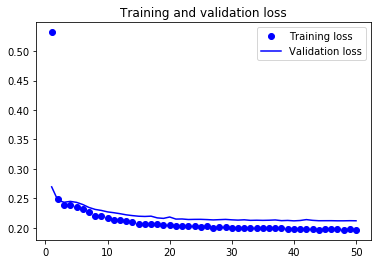

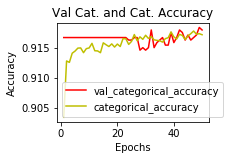

In [41]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

cv = KFold(n_splits=5,shuffle=True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []
    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # Initializing variables for word2vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,
                     window = context, sample = downsampling)
    
    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    

    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    validsiz=200;
    
    y_train = y_train -1
    y_test = y_test-1
    x_val= testDataVecs[0:validsiz]
    y_val = y_test[0:validsiz]
    y_val = to_categorical(y_val, num_classes=12)    
    y_train = to_categorical(y_train, num_classes=12)

    lstm_model = get_model()
    #,validation_data=(x_val, y_val)
    history = lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=50,validation_data=(x_val, y_val))
    y_pred = lstm_model.predict(testDataVecs)
    # Save any one of the 8 models.
    if count == 1:
         lstm_model.save('final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    '''
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    '''
    
    import matplotlib.pyplot as plt
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


    plt.subplot(222)
    valacc = history.history['val_acc']
    acc = history.history['acc']
    plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
    plt.plot(epochs, acc, 'y', label='categorical_accuracy')
    plt.title('Val Cat. and Cat. Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    break
    count += 1


In [43]:
model = keras.models.load_model("final_lstm.h5")  # Load Keras model we learned using KerasPractice 
test = trainDataVecs[1:2]
test_p = y_train[1:2]
print(test_p)
model.predict(test)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


array([[1.8432736e-04, 6.3183904e-04, 5.1012635e-04, 2.4204850e-03,
        1.3749599e-03, 2.3709595e-02, 3.4940720e-02, 3.2466865e-01,
        2.4821348e-01, 2.5709864e-01, 8.0462538e-02, 2.5904387e-02]],
      dtype=float32)

In [72]:
X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'), encoding='ISO-8859-1')
Xplus = pd.read_csv(os.path.join(DATASET_DIR, 'Prompt-1.csv'), encoding='ISO-8859-1')
X = (X[(X["essay_set"] == 1)])
#X = (X[(X["essay_set"] == 1)])
X = X.dropna(axis=1)
#newset = X.set_index('essay_id').join(Xplus.set_index('EssayID'))
newset =X.merge(Xplus,left_on='essay_id', right_on='EssayID')
print(newset.columns)
newset = newset[["essay_id","essay_set","essay", "domain1_score",'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions']]
newset.to_csv("essay_set1_merged.csv",index=False);

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score', 'domain1_score_copy', 'EssayID', 'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions'],
      dtype='object')
